<a href="https://colab.research.google.com/github/roshinisanikop/Mitigating_Bias_in_Facial_Recognition_using_Seldonian_Framework/blob/main/Working_Seldonian_Model_Facial_recog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
! pip install --upgrade seldonian-engine

In [53]:
# Comment the following if you are running your code locally

# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs682/assignments/assignment1++++++++++++

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
# !apt-get install git
# !git clone https://github.com/seldonian-toolkit/Experiments.git "/content/drive/My Drive/ColabNotebooks/682_project/seldonian_experiment"


In [55]:

# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt
import numpy as np

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.5.1+cu121
torchvision version: 0.20.1+cu121


In [56]:
! pip install datasets

## Data Preparation

In [57]:
from datasets import load_dataset
import pandas as pd

def load_fair_dataset_combined():
    # Load the dataset
    ds = load_dataset("HuggingFaceM4/FairFace", "0.25")

    # Convert train and test datasets to Pandas DataFrames
    df_train = ds['train'].to_pandas()
    df_test = ds['validation'].to_pandas()

    # Combine train and test data into a single DataFrame
    combined_df = pd.concat([df_train, df_test], ignore_index=True)

    # Return the combined DataFrame
    return df_train.iloc[:, 0:4], df_test.iloc[:, 0:4], combined_df.iloc[:, 0:4]

# Load and combine the dataset
# df_train, df_test, combined_df = load_fair_dataset_combined()
# df_train, df_test, combined_df


In [58]:
from datasets import load_dataset
from datasets import DatasetDict, Dataset
import pandas as pd

def load_dataset_2():
  ds = load_dataset("HuggingFaceM4/FairFace", "0.25")
  df_train = ds['train'].to_pandas()
  df_test = ds['validation'].to_pandas()

  # Step 1: Filter for races 3 and 5
  df_train_filtered = df_train[df_train['race'].isin([3, 5])]
  df_test_filtered = df_test[df_test['race'].isin([3, 5])]

  return df_train_filtered , df_test_filtered

# Load and combine the dataset
df_train, df_test = load_dataset_2()
df_train, df_test

(                                                   image  age  gender  race  \
 5      {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    3       0     3   
 8      {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    2       0     3   
 12     {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    3       0     5   
 15     {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    4       1     3   
 23     {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    4       1     3   
 ...                                                  ...  ...     ...   ...   
 86730  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    6       0     3   
 86731  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    3       1     5   
 86732  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    5       1     3   
 86733  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    4       0     3   
 86743  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    5       0     3   
 
        service_test  
 5             

In [59]:
data_train = df_train.sample(n = len(df_train), random_state = 42).iloc[:len(df_train)]
data_test = df_test.sample(n = len(df_test), random_state = 42).iloc[:len(df_test)]


In [60]:
import numpy as np
from PIL import Image
import io
from seldonian.utils.io_utils import save_pickle

def process_rgb_image(image_dict):
    try:
        # Load image from bytes
        image_bytes = image_dict['bytes']
        image = Image.open(io.BytesIO(image_bytes))

        # Convert image to RGB to ensure 3 channels
        image = image.convert("RGB")

        # Resize to (48, 48)
        image = image.resize((48, 48))

        # Convert to NumPy array
        image_array = np.array(image, dtype=np.float32)

        # Normalize to [0, 1]
        image_array /= 255.0

        return image_array
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

# Process the images
print("Processing RGB images...")
data_train['pixels'] = data_train['image'].apply(process_rgb_image)
data_test['pixels'] = data_test['image'].apply(process_rgb_image)

Processing RGB images...


In [61]:
combined = pd.concat([data_train, data_test], ignore_index=True)

In [62]:
# Convert processed images to a NumPy array
print("Converting images to NumPy array...")
X = np.array(combined['pixels'].tolist())  # Shape: (num_samples, 48, 48, 3)

# Reshape to (num_samples, 3, 48, 48)
# images = X.transpose(0, 3, 1, 2)
images =  X.reshape(X.shape[0], 3, 48, 48)

Converting images to NumPy array...


In [63]:
labels  = combined['gender'].values

In [64]:
# One-hot encode the 'race' column
combined['caucasian'] = (combined['race'] == 3).astype(int)  # 1 if race is 3, else 0
combined['not_caucasian'] = (combined['race'] != 3).astype(int)  # 1 if race is 5, else 0

race_three = combined['caucasian'].values
race_five = combined['not_caucasian'].values

sensitive_attrs = np.hstack((race_three.reshape(-1,1),race_five.reshape(-1,1)))

In [65]:
combined

,image,age,gender,race,service_test,pixels,caucasian,not_caucasian
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3,0,3,True,"[[[0.21568628, 0.34509805, 0.30980393], [0.235...",1,0
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,4,1,3,False,"[[[0.047058824, 0.039215688, 0.043137256], [0....",1,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,4,1,5,False,"[[[0.06666667, 0.0627451, 0.043137256], [0.086...",0,1
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3,1,3,False,"[[[0.68235296, 0.42745098, 0.27058825], [0.690...",1,0
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,1,1,3,False,"[[[0.42352942, 0.32156864, 0.19607843], [0.431...",1,0
...,...,...,...,...,...,...,...,...
33597,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,6,1,5,True,"[[[0.8509804, 0.92156863, 0.9372549], [0.80784...",0,1
33598,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,4,0,3,False,"[[[0.37254903, 0.23137255, 0.15294118], [0.239...",1,0
33599,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,4,0,3,True,"[[[0.19607843, 0.16470589, 0.2], [0.1882353, 0...",1,0
33600,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,4,1,3,False,"[[[0.105882354, 0.039215688, 0.023529412], [0....",1,0


In [66]:
sensitive_attrs

array([[1, 0],
       [1, 0],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

Unique races: [3 5]
Unique ages: [3 4 1 5 2 6 0 7 8]


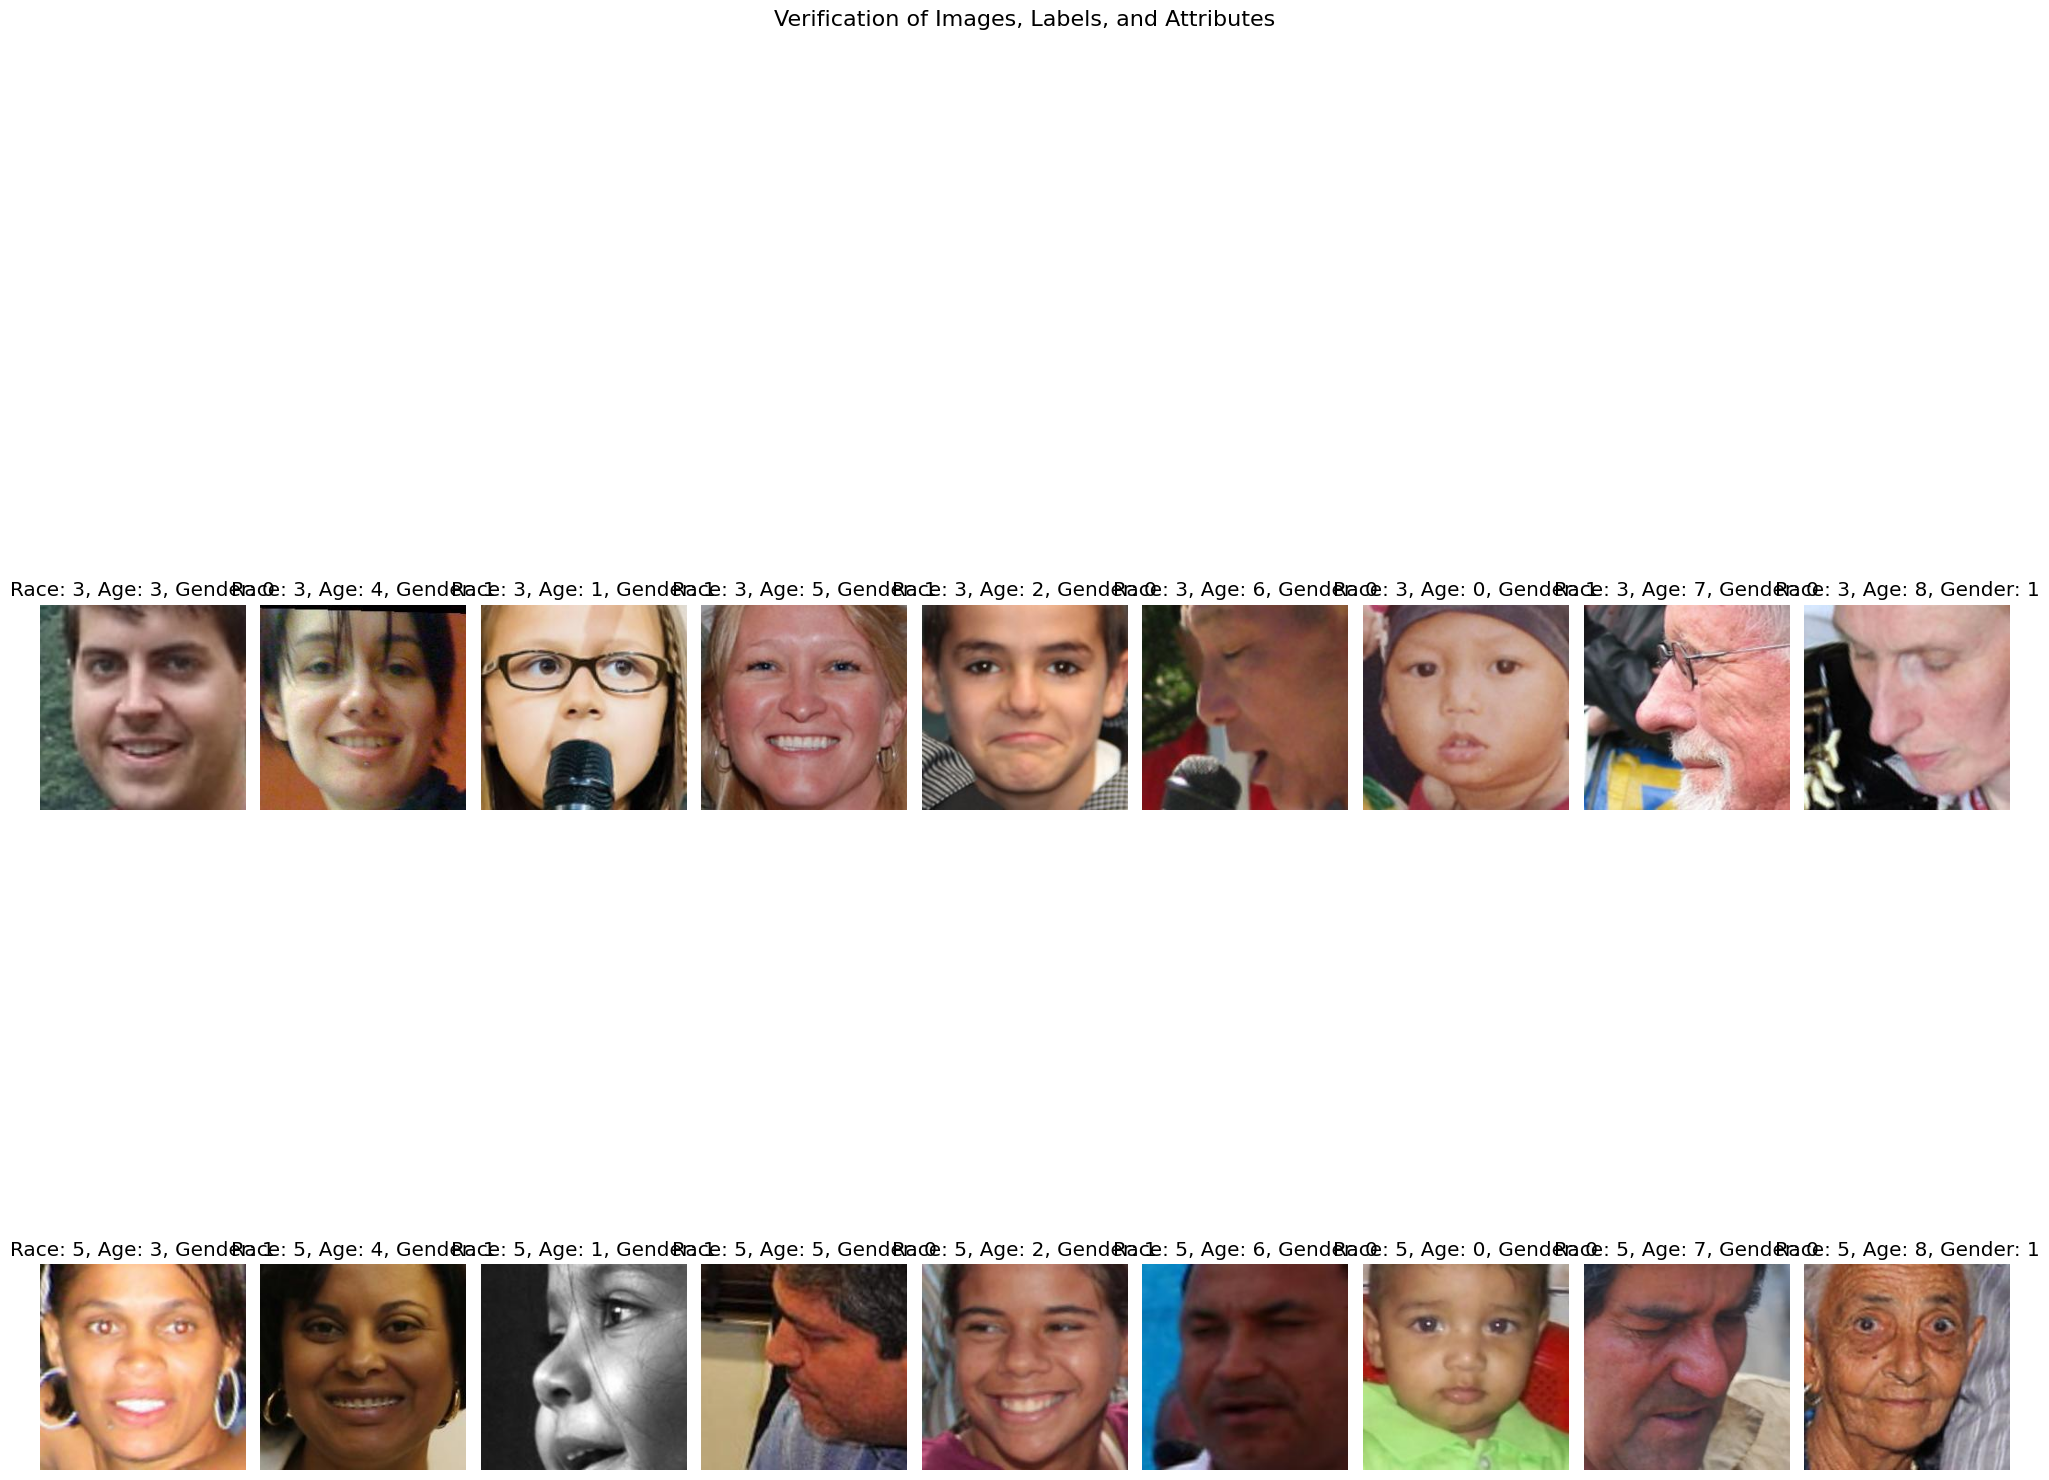

In [67]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import io

def verify_data(data):
    """
    Visualize one example for each combination of race and age values.
    Shows the image, race, age, and gender.

    :param data: DataFrame containing 'image', 'age', 'gender', and 'race' columns
    :type data: pd.DataFrame
    """
    unique_races = data['race'].unique()
    unique_ages = data['age'].unique()

    print("Unique races:", unique_races)
    print("Unique ages:", unique_ages)

    fig, axes = plt.subplots(len(unique_races), len(unique_ages), figsize=(20, 20))
    fig.suptitle("Verification of Images, Labels, and Attributes", fontsize=16)

    for i, race in enumerate(unique_races):
        for j, age in enumerate(unique_ages):
            # Filter data for the specific race and age
            filtered_data = data[(data['race'] == race) & (data['age'] == age)]
            if not filtered_data.empty:
                # Take the first example from the filtered data
                sample = filtered_data.iloc[0]
                image_bytes = sample['image']['bytes']
                image = Image.open(io.BytesIO(image_bytes))

                # Plot the image
                ax = axes[i, j]
                ax.imshow(image)
                ax.axis('off')

                # Add the metadata as title
                gender = sample['gender']
                ax.set_title(f"Race: {race}, Age: {age}, Gender: {gender}")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Example usage
verify_data(combined)


In [68]:
# Save to pickle files
savename_features = './drive/MyDrive/ColabNotebooks/682_project/features.pkl'
savename_labels = './drive/MyDrive/ColabNotebooks/682_project/labels.pkl'
savename_sensitive_attrs = './drive/MyDrive/ColabNotebooks/682_project/sensitive_attrs.pkl'

print("Saving features and labels...")
save_pickle(savename_features, images)
save_pickle(savename_labels, labels)
save_pickle(savename_sensitive_attrs, sensitive_attrs)

print("Processing complete.")

Saving features and labels...
Processing complete.


In [69]:
savename_features = './drive/MyDrive/ColabNotebooks/682_project/features.pkl'
savename_labels = './drive/MyDrive/ColabNotebooks/682_project/labels.pkl'
savename_sensitive_attrs = './drive/MyDrive/ColabNotebooks/682_project/sensitive_attrs.pkl'


## Running the Seldonian experiment

In [70]:
from seldonian.models.pytorch_model import SupervisedPytorchBaseModel
import torch.nn as nn
import torch

class FacialRecogCNNModel(nn.Module):
    def __init__(self):
        super(FacialRecogCNNModel, self).__init__()
        # Define all layers here
        self.cnn1=nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.cnn2=nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.cnn3=nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.cnn4=nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)

        self.relu=nn.ReLU()
        self.maxpool=nn.MaxPool2d(kernel_size=2)

        self.Batch1=nn.BatchNorm2d(16)
        self.Batch2=nn.BatchNorm2d(32)
        self.Batch3=nn.BatchNorm2d(64)
        self.Batch4=nn.BatchNorm2d(128)

        # Fully connected 1 (readout)
        self.fc1=nn.Linear(128 * 1 * 1, 128)
        self.fc2=nn.Linear(128,256)
        self.fc3=nn.Linear(256,2)
        self.softmax=nn.Softmax(dim=1)

    def forward(self, x):
        # Call all layers here. This does the forward pass.
        out=self.cnn1(x)
        out=self.relu(out)
        out=self.maxpool(out)
        out=self.Batch1(out)

        out=self.cnn2(out)
        out=self.relu(out)
        out=self.maxpool(out)
        out=self.Batch2(out)

        out=self.cnn3(out)
        out=self.relu(out)
        out=self.maxpool(out)
        out=self.Batch3(out)

        out=self.cnn4(out)
        out=self.relu(out)
        out=self.maxpool(out)
        out=self.Batch4(out)

        # Resize
        # Original size: (100, 32, 7, 7)
        # New out size: (100, 32*7*7)
        out=torch.flatten(out,start_dim=1)

        # Linear functions (readout)
        out=self.fc1(out)
        out=self.fc2(out)
        out=self.fc3(out)

        # Softmax to make probabilities
        out=self.softmax(out)[:,1]

        return out

class PytorchFacialRecog(SupervisedPytorchBaseModel):
    def __init__(self,device):
        """ Implements a CNN with PyTorch.
        CNN consists of four hidden layers followed
        by a linear + softmax output layer.

        Inputs are N,1,48,48 where N is the number of them,
        1 channel and 48x48 pixels.
        """
        super().__init__(device)

    def create_model(self,**kwargs):
        """ Create the pytorch model and return it
        """
        return FacialRecogCNNModel()

In [71]:
# Define parameters
device = 'cpu'  # or 'cuda' if using a GPU
num_classes = 2  # Example: 9 age categories

# Instantiate the model
model = PytorchFacialRecog(device=device)

# Create the CNN model
cnn_model = model.create_model()

# Print model architecture
print(cnn_model)


FacialRecogCNNModel(
  (cnn1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cnn2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (cnn3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (cnn4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Batch4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)


In [89]:
from seldonian.spec import SupervisedSpec
from seldonian.dataset import SupervisedDataSet
from seldonian.utils.io_utils import load_pickle,save_pickle
from seldonian.models import objectives
from seldonian.seldonian_algorithm import SeldonianAlgorithm
from seldonian.parse_tree.parse_tree import (
    make_parse_trees_from_constraints)
import autograd.numpy as np
from types import SimpleNamespace

In [90]:
regime='supervised_learning'
sub_regime='classification'
# features = load_pickle(savename_features)
# labels = load_pickle(savename_labels)
# sensitive_attrs = load_pickle(savename_sensitive_attrs)

features = images
labels = labels
sensitive_attrs = sensitive_attrs

frac_data_in_safety = 0.5
sensitive_col_names = ['race_three','race_other']

meta_information = SimpleNamespace(
    feature_col_names=['image'],
    label_col_names=['gender'],
    sensitive_col_names=sensitive_col_names,
    sub_regime=sub_regime,
    regime=regime
)

print("Making SupervisedDataSet...")
dataset = SupervisedDataSet(
    features=features,
    labels=labels,
    sensitive_attrs=sensitive_attrs,
    num_datapoints= len(features),
    meta = meta_information)

constraint_strs = ['min((ACC | [race_three])/(ACC | [race_other]),(ACC | [race_other])/(ACC | [race_three])) >= 0.8']
deltas = [0.05]
print("Making parse trees for constraint(s):")
print(constraint_strs," with deltas: ", deltas)


parse_trees = make_parse_trees_from_constraints(
    constraint_strs,deltas,regime=regime,
    sub_regime=sub_regime,columns=sensitive_col_names)

initial_solution_fn = model.get_model_params

primary_objective_fn = objectives.binary_logistic_loss


Making SupervisedDataSet...
Making parse trees for constraint(s):
['min((ACC | [race_three])/(ACC | [race_other]),(ACC | [race_other])/(ACC | [race_three])) >= 0.8']  with deltas:  [0.05]


In [91]:

spec = SupervisedSpec(
    dataset=dataset,
    model=model,
    parse_trees=parse_trees,
    frac_data_in_safety=frac_data_in_safety,
    primary_objective=primary_objective_fn,
    use_builtin_primary_gradient_fn=False,
    sub_regime=sub_regime,
    initial_solution_fn=initial_solution_fn,
    optimization_technique='gradient_descent',
    optimizer='adam',
    optimization_hyperparams={
        'lambda_init'   : np.array([0.5]),
        'alpha_theta'   : 0.001,
        'alpha_lamb'    : 0.001,
        'beta_velocity' : 0.9,
        'beta_rmsprop'  : 0.95,
        'use_batches'   : True,
        'batch_size'    : 237,
        'n_epochs'      : 10,
        'gradient_library': "autograd",
        'hyper_search'  : None,
        'verbose'       : True,
    },

    batch_size_safety=2000
)
save_pickle('./spec.pkl',spec,verbose=True)

KeyboardInterrupt: 

In [ ]:
# SA = SeldonianAlgorithm(spec)
# passed_safety,solution = SA.run(debug=True,write_cs_logfile=True)

# if passed_safety:
#     print("Passed safety test.")
# else:
#     print("Failed safety test")

In [ ]:
# cs_dict = SA.get_cs_result()

In [ ]:
# print(cs_dict)

In [ ]:
# from seldonian.utils.io_utils import load_pickle
# from seldonian.utils.plot_utils import plot_gradient_descent
# import matplotlib.pyplot as plt

# if passed_safety:
#     cs_file = '/content/logs/candidate_selection_log0.p'
#     solution_dict = load_pickle(cs_file)

#     fig = plot_gradient_descent(solution_dict,
#         primary_objective_name='log loss',
#         save=False)
#     plt.show()

# Running the Seldonian Experiment


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/ColabNotebooks/682_project/seldonian_experiment')

import experiments


In [ ]:
import os, math
import numpy as np
import torch
from experiments.generate_plots import SupervisedPlotGenerator
from seldonian.utils.io_utils import load_pickle

In [ ]:
len(dataset.features)

In [ ]:
from collections import defaultdict

run_experiments = True
make_plots = True
save_plot = False
include_legend = True
performance_metric = 'Accuracy'
model_label_dict = {
    'qsa':'Quasi-Seldonian CNN',
    'facial_recog_cnn': 'CNN baseline (no constraint)',
    'weighted_random_classifier': 'Weighted-random classifier'}

n_trials = 10

data_fracs = np.logspace(-3,0,15)
niter = 500 # how many iterations we want in each run. Overfitting happens with more than this.
batch_size=332
data_sizes=data_fracs*len(dataset.features) # number of points used in candidate selectionin each data frac
n_batches=data_sizes/batch_size # number of batches in each data frac
n_batches=np.array([math.ceil(x) for x in n_batches])
n_epochs_arr=niter/n_batches # number of epochs needed to get to 1200 iterations in each data frac
n_epochs_arr = np.array([math.ceil(x) for x in n_epochs_arr])

batch_epoch_dict = {data_fracs[ii]:[batch_size,n_epochs_arr[ii]] for ii in range(len(data_fracs))}
n_workers = 1

results_dir = f'/content/drive/MyDrive/ColabNotebooks/682_project'
os.makedirs(results_dir,exist_ok=True)
plot_savename = os.path.join(results_dir,f'facial_gender_experiment.pdf')
verbose=False

# Use entire original dataset as ground truth for test set
dataset = spec.dataset
test_features = dataset.features
test_labels = dataset.labels

# Setup performance evaluation function and kwargs
# of the performance evaluation function

def perf_eval_fn(y_pred,y,**kwargs):
    if performance_metric == 'Accuracy':
        # 1 - error rate
        v = np.where(y!=1.0,1.0-y_pred,y_pred)
        return sum(v)/len(v)

# Use same torch device as we used for running the Engine
device = spec.model.device
perf_eval_kwargs = {
    'X':test_features,
    'y':test_labels,
    'device':device,
    'eval_batch_size':2000
    }

constraint_eval_kwargs = {
    'eval_batch_size':2000
    }


# plot_generator = SupervisedPlotGenerator(
#     spec=spec,
#     n_trials=n_trials,
#     data_fracs=data_fracs,
#     n_workers=n_workers,
#     datagen_method='resample',
#     perf_eval_fn=perf_eval_fn,
#     constraint_eval_fns=[],
#     constraint_eval_kwargs=constraint_eval_kwargs,
#     results_dir=results_dir,
#     perf_eval_kwargs=perf_eval_kwargs,
#     batch_epoch_dict=batch_epoch_dict
#     )

# Storage for results
plot_data = defaultdict(lambda: defaultdict(list))

if run_experiments:
    # quasi-Seldonian experiment

    for data_frac in data_fracs:
      for trial_i in range(n_trials):

        try:
          SA = SeldonianAlgorithm(spec)
          passed_safety,solution = SA.run(debug=True,write_cs_logfile=True)

          if passed_safety:
            X_test = perf_eval_kwargs["X"]
            Y_test = perf_eval_kwargs["y"]
            model = SA.model
            # Batch the prediction if specified
            cs_dict = SA.get_cs_result()
            accuracy = perf_eval_fn(solution, test_labels)
            plot_data[data_frac]['accuracy'].append(accuracy)
            plot_data[data_frac]['constraint_satisfaction'].append(cs_dict['best_g'][0] <= 0)
            plot_data[data_frac]['solution_found'].append(passed_safety)

        except (ValueError, ZeroDivisionError):
            plot_data[data_frac]['solution_found'].append(False)




In [ ]:
# Generate Plots
if make_plots:
    mean_accuracy = [np.mean(plot_data[df]['accuracy']) for df in data_fracs]
    prob_solution = [np.mean(plot_data[df]['solution_found']) for df in data_fracs]
    prob_constraints = [np.mean(plot_data[df]['constraint_satisfaction']) for df in data_fracs]

    # Plot 1: Accuracy of Model vs. Amount of Data
    plt.figure()
    plt.plot(data_fracs, mean_accuracy, marker='o', label='Model Accuracy')
    plt.xscale('log')
    plt.xlabel('Amount of Data (fraction)')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Amount of Data')
    if include_legend:
        plt.legend()
    if save_plot:
        plt.savefig(os.path.join(results_dir, 'accuracy_vs_data.pdf'))
    plt.show()

    # Plot 2: Probability of Solution vs. Amount of Data
    plt.figure()
    plt.plot(data_fracs, prob_solution, marker='o', label='Probability of Solution')
    plt.xscale('log')
    plt.xlabel('Amount of Data (fraction)')
    plt.ylabel('Probability of Solution')
    plt.title('Probability of Solution vs Amount of Data')
    if include_legend:
        plt.legend()
    if save_plot:
        plt.savefig(os.path.join(results_dir, 'prob_solution_vs_data.pdf'))
    plt.show()

    # Plot 3: Probability of Meeting Constraints vs. Amount of Data
    plt.figure()
    plt.plot(data_fracs, prob_constraints, marker='o', label='Probability of Meeting Constraints')
    plt.xscale('log')
    plt.xlabel('Amount of Data (fraction)')
    plt.ylabel('Probability of Meeting Constraints')
    plt.title('Probability of Meeting Constraints vs Amount of Data')
    if include_legend:
        plt.legend()
    if save_plot:
        plt.savefig(os.path.join(results_dir, 'prob_constraints_vs_data.pdf'))
    plt.show()